In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os

# 0.1 General Helpers

In [41]:
def print_df(df: pd.DataFrame):
    """printing data in table for easy readable in console output.

    Args:
        df (pd.DataFrame): any Dataframe for visualization
    """
    
    df.columns = df.columns.str.replace(' ', '')
    
    # Determine column width (including index)
    widths = [max(len("t"), 10)] + [max(len(str(x)), 20) for x in df.columns]

    # Center header (including “Index” as column index)
    header = " | ".join(str(col).center(width) for col, width in zip(["t"] + list(df.columns), widths))

    # Center values (including row index)
    rows = "\n".join(
    " | ".join(str(val).center(width) for val, width in zip([index] + list(row), widths))
    for index, row in zip(df.index, df.values)
    )

    # Merge and output
    print(header)
    print("-" * len(header))  # Dividing line
    print(rows)
    
    
def change_energy_units(
    values: list, 
    actual_unit: str, 
    target_unit: str):
    """Iterates through a list of values (int/float) and checks unit. If actual and target units differ it processes 
    all values into new unit and gives back new list as return value.

    Args:
        values (list): power or energy values
        actual_unit (str): actual unit of input values
        target_unit (str): target unit for values

    Returns:
        list: target values with intended target unit.
    """
    target_values = []
    # Permitted units
    kW_units = ['kW', 'kWh']
    MW_units = ['MW', 'MWh']
    GW_units = ['GW', 'GWh']
    for value in values: 
        if actual_unit in kW_units and target_unit in MW_units: 
            target_values.append(round((value / 1000),2))
        elif actual_unit in kW_units and target_unit in GW_units:
            target_values.append(round((value / 1000000),2))
        elif actual_unit in kW_units and target_unit in kW_units:
            target_values.append(round((value),2))
        elif actual_unit in MW_units and target_unit in GW_units:
            target_values.append(round((value / 1000),2))
        elif actual_unit in MW_units and target_unit in kW_units:
            target_values.append(round((value * 1000),2))
        elif actual_unit in MW_units and target_unit in MW_units:
            target_values.append(round((value),2))
        elif actual_unit in GW_units and target_unit in MW_units:
            target_values.append(round((value * 1000),2))
        elif actual_unit in GW_units and target_unit in kW_units:
            target_values.append(round((value * 1000000),2))
        elif actual_unit in GW_units and target_unit in GW_units:
            target_values.append(round((value),2))
        else: 
            raise KeyError("Unit not found. Check spelling or add unit in function.")
    # print(f"Calculation done for actual unit: {actual_unit} to target unit: {target_unit}")
    return target_values

def change_cost_dimension(
    values: list, 
    target_unit: str
):
    """Function to change unit of costs from € to thousand or million €.

    Args:
        values (list): List of € values.
        target_unit (str): wished unit as string.

    Raises:
        KeyError: if unit is not listed in function, error appears. 

    Returns:
        list: list of changed cost values.
    """
    # print("[change_cost_dimension] input values: ", values)
    target_values = []
    for value in values: 
        if target_unit == '€':
            target_values.append(round((value),2))
        elif target_unit == 'T €': 
            target_values.append(round((value / 1000),2))
        elif target_unit == 'Mio. €':
            target_values.append(round((value / 1000000),2))
        elif target_unit == 'Mrd. €': 
            target_values.append(round((value / 1000000000),2))
        else: 
            raise KeyError("Unit not found. Check spelling or add unit in function.")
    # print("[change_cost_dimension] target values: ", target_values)
    return target_values

def get_weeks_from_timestamp(
    timestamps: list
    ):
    """generates weeks from input-dates by cutting string and find out KW. Result is a list of Strings. 
    Useful for plotting diagrams based on weeks and not months.

    Args:
        timestamps (list): list of timestamps in format: ['YYYY-MM-DD/YYYY-MM-DD', ...] if weeks are set as granularity.

    Returns:
        list: list with strings of weeknumber [01, 02, 03, ...] based on startdate (suitbale for x axis)
    """
    weeks = []
    for timestamp in timestamps:
        start_str = timestamp.split('/')[0]  # note only the start value before the '/'
        # Convert start date to datetime
        start_date = datetime.strptime(
            start_str, 
            "%Y-%m-%d"
            )
        # Retrieve calendar week
        start_week = start_date.isocalendar()[1]
        weeks.append(start_week)
        
    return weeks


def get_months_from_timestamp(
    timestamps: list
    ):
    """Adjust the strings contained by default for the month, 
    by deleting the year and leaving only the month as a string.

    Args:
        timestamps (list): input timestamps in list ['YYYY-MM', ...]

    Returns:
        list: converted list with months as strings
    """
    months = []
    for timestamp in timestamps:
        year = timestamp[:4]
        months.append(timestamp.replace(f'{year}-', ''))

    return months

## 0.2 Load data from csv output:

In [42]:
def load_csv_results_in_df(
    input_path: str
    ):
    """Load output csv in dataframe.

    Args:
        input_path (str): path from which csv is loaded. 

    Returns:
        pd.DataFrame: csv data in dataframe as table type.
    """
    input_values_df = pd.read_csv(
        input_path, 
        index_col=0
        )
    return input_values_df

# 1 Functions for filtering and extracting values

In [50]:
def add_timestamp_and_filter(
    input_df: pd.DataFrame, 
    start_time: str, 
    end_time: str, 
    time_column = 'date'
    ):
    """Insert Dates (YYYY-MM-DD HH:MM) in DataFrame and filter after given start and end date.
    Assumption: 8784 values (366 days) beginning at 01.01.2025.

    Args:
        df (pd.DataFrame, optional): Input Dataframe from output. Defaults to pd.DataFrame.
        start_time (str, optional): first date and time for filtering. Defaults to str.
        end_time (str, optional): end date and time for filtering. Defaults to str.
        time_column (str, optional): name of column with time steps. Default value 'date'.

    Returns:
        pd.DataFrame: added colomn with dates and time, and filtered Dataframe after time span.
    """
    # Create List of dates and hours belonging to timestep:
    dates = list(
        pd.date_range(
            '2028-01-01 00:00', 
            periods=8784, #TODO: Funktion ermittlung periods normales und Schaltjahr einfügen!
            freq='H')
        )
    input_df.insert(
        0, 
        time_column, 
        dates, 
        allow_duplicates=False
        )
    input_df[time_column] = pd.to_datetime(input_df[time_column])
    # Delete blank spaces of colomn names:
    input_df.columns = input_df.columns.str.replace(' ', '')
    # filtered df after time span:
    return input_df[(input_df[time_column] >= pd.Timestamp(start_time)) & (input_df[time_column] <= pd.Timestamp(end_time))]

def extract_price_data_to_dict(
    time_filtered_df: pd.DataFrame, 
    assets: tuple,
    key_gas_price: str,
    key_power_price: str,
    key_h2_price: str,
    H2_PRICE=None
    ):
    """
    Reads certain price and CO2 columns belonging to relevant assets for the diagram from a DataFrame 
    and saves them in a dictionary.

    Parameters:
        time_filtered_df (pd.DataFrame): filtered DataFrame by time.
        assets (tuple): A tuple with all assets that are to be displayed.
        key_gas_price (str): String for gas price column in csv file. 
        key_power_price (str): String for power price column in csv file. 

    Returns:
        extracted_columns_dict: Dictionary with asset name and variable as keys and belonging hourly data for set timespan as lists (= value).
    """
    # Generate the complete column names
    column_names = [key_gas_price, key_power_price, key_h2_price] # convert input data for price names in list # , key_h2_price
    for asset in assets:   
        column_names.append(str(f"{asset}.co2")) # get keys of set assets in input data emitting co2 
        column_names.append(str(f"{asset}.power"))
        column_names.append(str(f"{asset}.gas"))
    print("[extract_price_data_to_dict] column names: ", column_names)
    # Filter the desired columns:
    extracted_columns_dict = {col: list(time_filtered_df[col]) for col in column_names if col in time_filtered_df.columns}
    
    # Konstante hinzufügen!
    # print("[extract_price_data_to_dict] H2_PRICE: ", H2_PRICE)
    extracted_columns_dict[key_h2_price] = [H2_PRICE] * len(extracted_columns_dict[key_gas_price])
    print("[extract_price_data_to_dict] H2_PRICE in price data: ", extracted_columns_dict[key_h2_price])
    # print("[extract_price_data_to_dict] extracted_columns_dict[key_h2_price]: ", extracted_columns_dict[key_h2_price])
    return extracted_columns_dict

def get_time_data_for_plot(
    time_filtered_df: pd.DataFrame, 
    granularity: str, 
    time_column='date'
): 
    """
    Generates time values for the x-axis depending on the selected granularity:
    - Hourly values as timestamps (always included)
    - If desired: monthly figures, calendar weeks or daily values (day & month)

    Args:
        time_filtered_df (pd.DataFrame): Time-filtered DataFrame with timestamps as index.
        granularity (str): 'hour', 'day', 'week' oder 'month'.
        time_column (str, optional): name of column with timestamps. Default: 'date'.

    Returns:
        tuple: (Hourly timestamps, dict with values for the x-axis based on granularity)
    """
    # Ensure that the index is set as datetime
    time_filtered_df = time_filtered_df.copy()
    time_filtered_df[time_column] = pd.to_datetime(time_filtered_df[time_column])
    time_filtered_df.set_index(time_column, inplace=True)
    # hourly timestamps (always contained))
    hourly_timestamps = time_filtered_df.index.to_list()
    # X-axis ticks dependant on set granularity
    first_occurrences_dict = {}
    if granularity == 'hour':
        for i, ts in enumerate(hourly_timestamps):
            hour = ts.strftime('%Y-%m-%d %H:%M')  # Extract the hour and minute (e.g. “14:30”)
            first_occurrences_dict[hour] = i
    elif granularity == 'day':
        # Identify the first timestamp of each day
        for i, ts in enumerate(hourly_timestamps):
            day = ts.strftime('%d-%m')  # Extract the date without time
            if day not in first_occurrences_dict:
                first_occurrences_dict[day] = i  # Save the index of the first occurrence
    
    elif granularity == 'week':
        # get week of calendar as number (1-53)
        for i, ts in enumerate(hourly_timestamps):
            week = f"KW {ts.strftime('%U')}"  # Extract the date without time
            if week not in first_occurrences_dict:
                first_occurrences_dict[week] = i  # Save the index of the first occurrence
    
    elif granularity == 'month': 
        # extract month as number (1-12)
        for i, ts in enumerate(hourly_timestamps):
            month = ts.strftime('%m')  # Extract the date without time
            if month not in first_occurrences_dict:
                first_occurrences_dict[month] = i  # Save the index of the first occurrence
    else: 
        raise ValueError(f"Granularity '{granularity}' not known. Please use 'hour', 'day', 'week', or 'month'.")
    return hourly_timestamps, first_occurrences_dict

def insert_data_to_df(
    csv_filepath: str,
    input_df: pd.DataFrame
):
    """
    Reads a csv data and extract name of file as column name. Adds values as new column in DataFrame. 

    Args:
        input_df (pd.DataFrame): existing DataFrame in which data is to be added.
        csv_filepath (str): Complete path of csv data file. 

    Returns:
        pd.DataFrame: updated DataFrame with new column.

    Raises:
        ValueError: If amount of values does not fit amount of lines occur this error.
    """

    # Extract the file name without ending as column name
    new_column_name = os.path.splitext(os.path.basename(csv_filepath))[0]

    # Read the CSV file (assuming it contains a column)
    new_values_df = pd.read_csv(csv_filepath)
    
    # Get the values of the first column
    new_values = new_values_df.iloc[:, 1].tolist()
    
    # Check whether the number of values matches the number of rows in the DataFrame
    if len(new_values) != len(input_df):
        raise ValueError(f"Fehler: Anzahl der neuen Werte ({len(new_values)}) passt nicht zur Anzahl der Zeilen im DataFrame ({len(input_df)}).")

    # Add the new column
    input_df[new_column_name] = new_values
    print(f"[insert_data_to_df] Data from {new_column_name}.csv added to df!")
    return input_df
    
def get_data_for_cost_simulation(
    key_gas_price: str,
    key_power_price: str,
    key_h2_price: str,
    assets: tuple,
    time_filtered_df: pd.DataFrame,
    H2_PRICE = None
):  
    """Function for getting cost values from output csv table. Also necessary data is loaded by assets tuple to calculate related costs. 
    H2_PRICE is just placeholder for putting constant value in list. Later it needs to be replaced by data from csv with key (already preparated).

    Args:
        key_gas_price (str): Name of column from gas price.
        key_power_price (str): Name of column from power price.
        key_h2_price (str): Name of column from h2 price.
        assets (tuple): Tuple with names of assets that are relevant for cost calculation.
        time_filtered_df (pd.DataFrame): dataframe from csv output already given in correct time span and granularity.
        H2_PRICE (_type_, optional): Constant H2_PRICE until h2_price is listed in csv output. Defaults to None. 

    Returns:
        dict: Dictionary with all relevant cost and energy data.
    """
    
    # Generate the complete column names
    column_names = [key_gas_price, 
                    key_power_price, 
                    key_h2_price,
                    'electrical_grid.power_balance',
                    'heat_grid.heat_feedin',
                    'hydrogen_grid.hydrogen_balance',
                    'ngas_grid.ngas_balance'
                    ] # convert input data for price names in list
    
    for asset in assets:   
        column_names.append(str(f"{asset}.co2")) # get keys of set assets in input data emitting co2 √
    print("[get_data_for_cost_simulation] column names: ", column_names)
    
    # Filter the desired columns:
    extracted_columns_dict = {col: list(time_filtered_df[col]) for col in column_names if col in time_filtered_df.columns}
    # print("[get_data_for_cost_simulation] Data from CSV: ", extracted_columns_dict[key_h2_price])
    extracted_columns_dict[key_h2_price] = [H2_PRICE] * len(extracted_columns_dict[key_gas_price])
    print(f"[get_data_for_cost_simulation] H2_values from {key_h2_price}.csv: ", extracted_columns_dict[key_h2_price])
    # print("[get_data_for_cost_simulation] constant H2_Price: ", extracted_columns_dict[key_h2_price])
    # for t in range(0, len(column_names)):
    #     print(f"[get_data_for_cost_simulation] Data value no. in columns dict {t}", extracted_columns_dict[column_names[t]])
    
    return extracted_columns_dict

# 2. Calculate CSS: 

In [51]:
def calculate_css(
    price_dict: dict,
    key_gas_price: str,
    key_electr_price: str,
    P_CO2: float,
    eta_el: float,
    CONVERSION_CALORIFIC_FACTOR: float,
    EMISSION_FACTOR: float
): 
    """Calculates the CSS hourly based on the input and Df data of the dictionary and saves it in a list.

    Args:
        price_dict (dict): Dictionary with price data from csv. 
        key_gas_price (str): key of gas price for column in csv or key of price_dict. 
        key_electr_price (str): key of electricity revenue for column in csv or key of price_dict.
        P_co2 (float): key for price of Co2 in €/t. Currently a constant. 
        eta_el (float): electric efficiency of power plant. 
        CONVERSION_CALORIFIC_FACTOR (float): factor of calorific value from lower to upper value.
        EMISSION_FACTOR (float): factor of natural gas. 

    Raises:
        KeyError: Error if necessary price data is not in csv. Co2 needs to be added in condition!

    Returns:
        list: list of calculated css values for plot (y-axis)
    """
    # all necessary economic data is necessary for calculation:
    if key_gas_price not in price_dict or key_electr_price not in price_dict:
        raise KeyError(f"[calculate_css] Keys {key_gas_price} or {key_electr_price} are missing in price_dict")
    # print("P_CO2: ", P_CO2)
    # print("eta_el: ", eta_el)
    # print("alpha: ", alpha)
    # print("beta: ", beta)
    css_values = []
    # formula of target function:
    for P_power, P_gas in zip(price_dict[key_electr_price], price_dict[key_gas_price]): 
        css = P_power - (1/eta_el) * (CONVERSION_CALORIFIC_FACTOR * P_gas + EMISSION_FACTOR * P_CO2) # formular calculation of CSS
        css_values.append(round(css, 2))
    return css_values    

# 3 Calculate Costs

In [52]:
def calculate_costs(
    cost_dict: pd.DataFrame,
    heat_price: float,
    co2_price: float,
    key_gas_price:str,
    key_h2_price:str,
    key_power_price:str
    ):
    """Calculating costs of simulation for each time step as set in target function. 
    If target function and inputs are changed, function needs to be adjusted.

    Args:
        cost_dict (pd.DataFrame): Dictionary with cost and energy data as needed in target function.
        heat_price (float): Actual heat price as constant value.
        co2_price (float): Actual CO2 price as constant value.
        key_gas_price (str): Key of gas price set in csv output to get value from dict.
        key_h2_price (str): Key of h2 price set in csv output to get value from dict.
        key_power_price (str): Key of power price set in csv output to get value from dict.

    Returns:
        list: list with costs for each time step (usually per hour) is returned for later plotting.
    """
    
    # Debugging: 
    # print("[calculate_costs] cost_dict", cost_dict)
    # print("[calculate_costs] heat_price", heat_price)
    # print("[calculate_costs] co2_price", co2_price) in €/t
    
    # extract values or use default ones (zeros if not given)
    num_time_steps = len(next(iter(cost_dict.values())))  # Anzahl der Zeitschritte bestimmen
    
    ngas_balance = cost_dict.get("ngas_grid.ngas_balance", [0] * num_time_steps)
    h2_balance = cost_dict.get("hydrogen_grid.hydrogen_balance", [0] * num_time_steps)
    power_balance = [value for value in cost_dict.get("electrical_grid.power_balance", [0] * num_time_steps)]
    heat_feedin = cost_dict.get("heat_grid.heat_feedin", [0] * num_time_steps)
    gas_price_series = cost_dict.get(key_gas_price, [0] * num_time_steps)
    h2_price_series = cost_dict.get(key_h2_price, [0] * num_time_steps)
    power_price_series = cost_dict.get(key_power_price, [0] * num_time_steps)

    # Looking dynamically for all CO2 emitting assets:
    co2_assets = [key for key in cost_dict.keys() if key.endswith(".co2")]
    
    # Initialize list for calculated costs per time stamp:
    costs_per_time = []
    
    # for Debugging: 
    power_costs=[]
    h2_costs=[]
    ngas_costs=[]
    co2_costs=[]
    heat_costs = []
    
    # Calculation of each time step:
    for i in range(num_time_steps): 
        total_cost = (
            ngas_balance[i] * gas_price_series[i] +
            h2_balance[i] * h2_price_series[i] +
            sum(cost_dict[co2_asset][i] * co2_price for co2_asset in co2_assets) + 
            power_balance[i] * power_price_series[i] -
            heat_feedin[i] * heat_price
        )
        costs_per_time.append(total_cost)
        
        # for debugging: 
        power_costs.append((power_balance[i] * power_price_series[i]))
        h2_costs.append((h2_balance[i] * h2_price_series[i]))
        ngas_costs.append((ngas_balance[i] * gas_price_series[i]))
        co2_costs.append(sum(cost_dict[co2_asset][i] * co2_price for co2_asset in co2_assets))
        heat_costs.append((heat_feedin[i] * heat_price))
    
    # For Debugging:
    # t = 1000
    # print("ngas_costs[0]: ", ngas_costs[t]/1000)
    # print("hydrogen_costs[0]", h2_costs[t]/1000)
    # print("power_costs[0]", power_costs[t]/1000)
    # print("co2_costs[0]", co2_costs[t]/1000)
    # print("heat_costs[0]", heat_costs[t]/1000)
    # print("Summe costs[0]:", (ngas_costs[t]+co2_costs[t]+power_costs[t]+h2_costs[t])/1000)
    # print("[calculate_costs] Total costs: ", sum((ngas_costs+co2_costs+power_costs+h2_costs))/1000)
    
    print("[calculate_costs] Summe ngas_costs T €: ", sum(ngas_costs)/1000) # cost unit is here T €. Unit is changed in plot function.
    print("[calculate_costs] Summe hydrogen_costs T €", sum(h2_costs)/1000)
    print("[calculate_costs] Summe power_costs T €", sum(power_costs)/1000)
    print("[calculate_costs] Summe co2_costs T €", sum(co2_costs)/1000)
    print("[calculate_costs] Costs per time step T €: ", costs_per_time)
    print("[calculate_costs] Total costs Mio. €: ", sum(costs_per_time)/1000000)
    print("[calculate_costs] Amount of cost values: ", len(costs_per_time))
    
    return costs_per_time
    
def cumulate_costs(
        costs_per_time: list
        ):
    """Function cumulating costs one after another. If done for one year last value corresponds target value of optimization.

    Args:
        costs_per_time (list): cost values that need to be cumulated.

    Returns:
        list: List with cumulated values.
    """
    cumulated_costs = []
    # counting variable
    total = 0
    # cumulating costs and save in list:
    for value in costs_per_time: 
        total += value
        cumulated_costs.append(total)
    print("[cumulate_costs] cumulated_costs (€): ", cumulated_costs)
    print("[cumulate_costs] target value (Mio. €): ", cumulated_costs[-1]/1000000)
    return cumulated_costs



# 4 Plot economic data

In [53]:
def plot_css(
    y_values: list,
    x_values: list,
    granularity: str,
    x_axis_occurencies: dict, 
    title_size: str,
    fontsize: str, 
    colors_dict: dict, 
    other_cost_data: dict, 
    key_gas_price: str,
    key_power_price: str, 
    key_h2_price: str,
    P_CO2: float,
    EMISSION_FACTOR: float,
    scenario_title = None
): 
    """Line chart plotting css in hourly granulation (ticks). Granularity of x axis is adjustable. 

    Args:
        y_values (list): css values to be plotted. 
        x_values (list): time data to be plotted. 
        granularity (str): wished granularity of x axis. 
        x_axis_occurencies (dict): occurencies to make sure that all time data is correct output on x axis.
        title_size (str): size of title font.
        fontsize (str): size of font in diagram.
        colors_dict (dict): dictionary with colors for set assets.
        other_cost_data (dict): Dictionary with other cost data than css.
        key_gas_price (str): key of gas price.
        key_power_price (str): key of power price.
        P_CO2 (float): constant of Co2 price.
        EMISSION_FACTOR (float): Emissionfactor for natural gas for calculating €/t in €/MWh.
        scenario_title (str, optional): Extra information in title for scenario data like (0 % H2, UE24). Default is to None.

    Returns:
        fig: Figure from matplotlib showing 4 types of cost data in one diagram as lines with different colors. 
    """
    
    shortened_label_h2 = 'H2_price'
    labels = list(colors_dict.keys())
    # plot CSS, gas_price, power price: 
    plt.style.use('dark_background') # dark Layout for slides
    fig, ax = plt.subplots(
        figsize=(16, 9), 
        facecolor="black"
        )
    ax.plot(
        x_values, 
        y_values, 
        marker=None, 
        linestyle='-', 
        label=labels[3], 
        color=colors_dict[labels[3]]
        )
    ax.plot(
        x_values, 
        other_cost_data[key_gas_price], 
        linestyle='-', 
        label=key_gas_price, 
        color=colors_dict[key_gas_price]
        )
    ax.plot(
        x_values, 
        other_cost_data[key_power_price], 
        linestyle='-', 
        label=key_power_price, 
        color=colors_dict[key_power_price]
        )
    ax.plot(
        x_values, 
        other_cost_data[key_h2_price], 
        linestyle='-', 
        label=shortened_label_h2, 
        color=colors_dict[key_h2_price]
        )
    print("H2_PRICE for plot: ", other_cost_data[key_h2_price])
    # given constant, needs to be integrated as list 
    repeated_co2_list = [P_CO2*EMISSION_FACTOR for _ in range(len(x_values))]
    ax.plot(
        x_values, 
        repeated_co2_list, 
        linestyle='-', 
        label=labels[2], 
        color=colors_dict[labels[2]]
        )
    # condition that more than 24 hours are plotted in one graph: 
    if granularity == 'hour': 
        ax.set_xticks([x_values[i] for i in x_axis_occurencies.values()])
        # Convert the complete date information to just “HH:MM” for the axis labeling
        ax.set_xticklabels(
            [key[-5:] for key in x_axis_occurencies.keys()],  # cut "HH:MM" out of string
            rotation=45 
            )
    else: 
        ax.set_xticks(
        [x_values[i] for i in x_axis_occurencies.values()],  # reduce X values
        [tick for tick in x_axis_occurencies.keys()],  # set labels as granularity
        rotation=45 
        )
    # Set title of axis. 
    ax.axhline(
        y=0, 
        color='white', 
        linewidth=0.7, 
        linestyle='-'
        )
    ax.set_xlabel(
        f"Time in {granularity}s", 
        fontsize=fontsize, 
        fontweight='bold'
        )
    ax.set_ylabel(
        "Clean Spark Spread in €/MWh", 
        fontsize=fontsize, 
        fontweight='bold'
        )
    ax.set_title(
        f"Clean Spark Spread of {scenario_title}", 
        fontsize=title_size, 
        fontweight='bold', 
        y=1.1
        )
    ax.grid(
        True, 
        color='gray', 
        linestyle='--', 
        linewidth=0.5, 
        zorder=1
        )
    ax.tick_params(
        axis='x', 
        labelsize=fontsize
        ) 
    ax.tick_params(
        axis='y', 
        labelsize=fontsize
        )
    ax.legend(
        loc="lower center",           # position of legend
        bbox_to_anchor=(0.5, 1.0, 0, 0),   # anchor point (x=0.5 for central, y=1.0 for above)
        ncol=5,                      # amount of columns in legend
        frameon=True,                # Frame around legend
        fontsize=fontsize,
        title_fontsize=fontsize
        )
    plt.tight_layout()
    # plt.show() # aktivieren, wenn nicht gespeichert wird. 
    return fig

def plot_costs(
    nested_y_values: list,
    x_values: list,
    granularity: str,
    x_axis_occurencies: dict, 
    title_size: str,
    fontsize: str, 
    colors_dict: dict,
    labels: list,
    target_cost_unit = '€',
    scenario_title = None
    ):
    """Function for plotting costs as line diagram. Possibility to plot more than one line because input data is a nested list.
    Function iterates through lists and plots each of it as line. Makes sense for plotting (cumulated) costs.

    Args:
        nested_y_values (list): cost data (other data) as lists in a list (nested lists). Function will iterate through list.
        x_values (list): Time values.
        granularity (str): granularity of time like months etc.
        x_axis_occurencies (dict): For labels of x-axis. Shows position, when values (like days) occur.
        title_size (str): for formatting title in plot.
        fontsize (str): for formatting font in plot.
        colors_dict (dict): set colors for different plots.
        labels (list): name of scenarios.
        target_cost_unit (str, optional): wished unit of costs. Defaults to '€'.
        scenario_title (_type_, optional): Name of plot as scenario. Defaults to None.

    Returns:
        fig: MatPlotLib figure for later saving.
    """

    plt.style.use('dark_background') # dark Layout for slides
    fig, ax = plt.subplots(
        figsize=(16, 9), 
        facecolor="black"
        )
    print("x-Values: ", x_values)
    
    for i, scenario_data in enumerate(nested_y_values):
        y_values = change_cost_dimension(
            values=scenario_data,
            target_unit=target_cost_unit
        )
        ax.plot(
            x_values, 
            y_values, 
            marker=None, 
            linestyle='-', 
            label=labels[i], 
            color=colors_dict[labels[i]]
            )
    
    plt.xlim(min(x_values), max(x_values))
    # condition that more than 24 hours are plotted in one graph: 
    if granularity == 'hour': 
        ax.set_xticks([x_values[i] for i in x_axis_occurencies.values()])
        # Convert the complete date information to just “HH:MM” for the axis labeling
        ax.set_xticklabels(
            [key[-5:] for key in x_axis_occurencies.keys()],  # cut "HH:MM" out of string
            rotation=45 
            )
    else: 
        ax.set_xticks(
        [x_values[i] for i in x_axis_occurencies.values()],  # reduce X values
        [tick for tick in x_axis_occurencies.keys()],  # set labels as granularity
        rotation=45 
        )
    # Set title of axis. 
    ax.axhline(
        y=0, 
        color='white', 
        linewidth=0.7, 
        linestyle='-'
        )
    ax.set_xlabel(
        f"Time in {granularity}s", 
        fontsize=fontsize, 
        fontweight='bold'
        )
    ax.set_ylabel(
        f"Costs in {target_cost_unit}", 
        fontsize=fontsize, 
        fontweight='bold'
        )
    ax.set_title(
        f"Costs of {scenario_title}", 
        fontsize=title_size, 
        fontweight='bold', 
        y=1.1
        )
    ax.grid(
        True, 
        color='gray', 
        linestyle='--', 
        linewidth=0.5, 
        zorder=1
        )
    ax.tick_params(
        axis='x', 
        labelsize=fontsize
        ) 
    ax.tick_params(
        axis='y', 
        labelsize=fontsize
        )
    ax.legend(
        loc="lower center",           # position of legend
        bbox_to_anchor=(0.5, 1.0, 0, 0),   # anchor point (x=0.5 for central, y=1.0 for above)
        ncol=5,                      # amount of columns in legend
        frameon=True,                # Frame around legend
        fontsize=fontsize,
        title_fontsize=fontsize
        )

    # plt.show() # aktivieren, wenn nicht gespeichert wird. 
    return fig
    

def save_plot(
    fig, 
    output_path: str, 
    filename: str, 
    dpi: int = 300, 
    format: str = "png"
    ):
    """Saves the given plot in a file.

    Args:
        fig (matplotlib.figure.Figure): The diagram to be saved.
        output_path (str): Path to folder for saving file.
        filename (str): The file name (incl. path) for the saved file.
        dpi (int): The resolution of the picture.
        format (str): Data formate (f. e. "png", "pdf", "svg").
    """
    if not os.path.exists(output_path):
        os.makedirs(output_path)  # Erstelle den Ordner (und alle übergeordneten Ordner falls nötig)
    output_file = os.path.join(
        output_path, 
        filename
        )
    plt.savefig(
        output_file, 
        format=format, 
        dpi=dpi, 
        facecolor="black", 
        transparent=False
        )
    plt.show()
    plt.close(fig)
    print(f"[save_plot] Diagram saved as: {output_file}")

# 5 Wrapper functions

In [54]:
def load_data(
    input_path: str, 
    start_time: str,
    end_time: str,
    add_data_path = None,
    time_column = 'date'
          ):
    """Wrapper function for loading data and filtering and setting time parameters for plot. 
    If data is not listed in csv output from optimization possibility to add data by setting add data path. If its a csv file the given
    data is added to df. In this case often used for setting h2 data in df because it was not in optimization before.

    Args:
        input_path (str): Path of csv output data.
        start_time (str): beginning of time span.
        end_time (str): end of time span.
        add_data_path (_type_, optional): Extra csv data that needs to be added to Dataframe. In this case often H2 data. Defaults to None.
        time_column (str, optional): Name of column in which date is listed. Defaults to 'date'.

    Returns:
        pd.DataFrame: Table with 
    """
    
    input_csv = load_csv_results_in_df(input_path=input_path)
    
    # possibility to load extra data into DataFrame:
    if add_data_path is not None: 
        df_adjusted = insert_data_to_df(input_df=input_csv, csv_filepath=add_data_path)
    else: 
        df_adjusted = input_csv
    
    # Filter and add time:
    df_with_time = add_timestamp_and_filter(
        input_df = df_adjusted, 
        start_time = start_time, 
        end_time = end_time, 
        time_column = time_column
        )
    return df_with_time
    

# 6 Main script

## 6.1 Input values: 

In [57]:

# 1 ! Definition Pathes, file and folder names for diagram:!
filename = 'css_test.png'
output_folder_name = 'clean_spark_spread'
colors_filename = "assigned_colors.json"
INPUT_PATH_CSS = '../data/output/ue24_ST-min_NW-ref_2028/1b_ue24_ST-min_NW-ref_2028_20250313_231545_output.csv'
H2_POWER_CSV_PATH = '../data/input/prices/ue24/h2_price_2028.csv' 
INPUT_PATHES_COSTS = ['../data/output/ue24_ST-min_NW-ref_2028/1b_ue24_ST-min_NW-ref_2028_20250313_231545_output.csv','../data/output/ue24_ST-min_NW-ref_2028/3b_ue24_ST-min_NW-ref_2028_20250314_000706_output.csv'] # '../data/output/ue24_ST-min_NW-ref_2028/2b_ue24_ST-min_NW-ref_2028_20250314_002620_output.csv'
OUTPUT_PATH = '../data/postprocessing/' + output_folder_name

# 2 ! time data: !
start_time = "2028-02-01 00:00" 
end_time = "2028-02-28 23:00"
granularity = 'day'

# 3 ! asset data: !
my_assets = ('chp_1', 'chp_2') # only assets with co2 variable
key_gas_price = 'gas_price' # from csv
key_power_price = 'power_price' # from csv
key_h2_price = 'h2_price_2028'
H2_PRICE = 160

# 4 ! Constant price parameter: !
P_CO2 = 95.98 # € / MWh ==> 95,98 €/t * 0,202 t/MWh = 19,37 € / MWh
P_HEAT = 0 # €
ETA_EL = 0.41
CONVERSION_CALORIFIC_FACTOR = 1.107
EMISSION_FACTOR = 0.2016

# 5 simulation parameters: 
get_css_plot = True
get_cost_plot = False
type_of_costs = 'cumulation' # 'cumulation' #'single'


# 6 Plot constants: 
scenario_title = "February 2028"
scenario_labels = ['0 % H2', '50 % H2', '100 % H2']
target_cost_unit = 'Mio. €' # 'Mrd. €' / 'T €' / '€'
title_size = 18
fontsize = 16

#TODO: set link to json soon.
# 7 set colors and keys of css and co2 price, manually (later load colors from same json as share of assets)
colors_dict = {
    "gas_price": [
        0.5843137255,
        0.3254901961,
        0.2784313725,
        1.0
    ],
    "power_price": [
        1.0, 
        0.85, 
        0.0, 
        1.0
    ],
    "CO2_price": [
        0.3882352941, 
        0.8470588235,
        0.2509803922,
        1.0
    ],
    "CSS": [
        0.2, 
        0.6, 
        1.0, 
        1.0
    ],
    "h2_price_2028": [
        0.5960784314,
        0.9607843137,
        1.0,
        1.0
    ],
    "0 % H2": [
        0.5843137255,
        0.3254901961,
        0.2784313725,
        1.0
    ],
"50 % H2": [
        1.0, 
        0.85, 
        0.0, 
        1.0
    ],
"100 % H2": [
        0.3882352941, 
        0.8470588235,
        0.2509803922,
        1.0
    ],
}

[insert_data_to_df] Data from h2_price_2028.csv added to df!
[extract_price_data_to_dict] column names:  ['gas_price', 'power_price', 'h2_price_2028', 'chp_1.co2', 'chp_1.power', 'chp_1.gas', 'chp_2.co2', 'chp_2.power', 'chp_2.gas']
[extract_price_data_to_dict] H2_PRICE in price data:  [160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 16

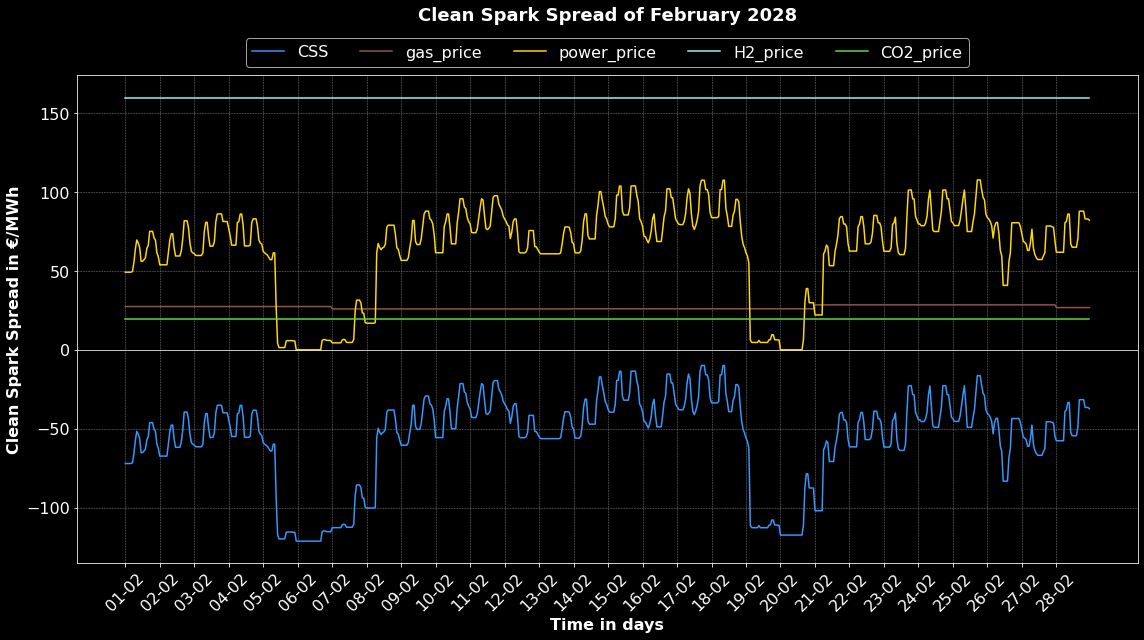

[save_plot] Diagram saved as: ../data/postprocessing/clean_spark_spread/css_test.png


In [58]:
if __name__ == "__main__":
    
    if get_css_plot == True:
        df_with_time = load_data(
        input_path=INPUT_PATH_CSS,
        add_data_path=H2_POWER_CSV_PATH,
        start_time=start_time,
        end_time=end_time,
    )
    # get css plot if chosen: 
        # print_df(df=df_with_time)
        price_dict = extract_price_data_to_dict(
            time_filtered_df = df_with_time, 
            assets = my_assets,
            key_gas_price = key_gas_price,
            key_power_price = key_power_price,
            key_h2_price = key_h2_price,
            H2_PRICE=H2_PRICE
        )
        trimmed_price_dict = {key: value[:5] for key, value in price_dict.items()}
        print("[Main] price dict: ", trimmed_price_dict)
        hourly_timestamps, occurencies_dict = get_time_data_for_plot(
            time_filtered_df=df_with_time,
            granularity=granularity
        )
        print("[Main] hourly_timestamps: ", hourly_timestamps[:5])
        print("[Main] occurencies_dict: ", occurencies_dict)
        css_values = calculate_css(
            price_dict = price_dict,
            key_gas_price = key_gas_price,
            key_electr_price = key_power_price,
            P_CO2=P_CO2,
            eta_el = ETA_EL,
            CONVERSION_CALORIFIC_FACTOR = CONVERSION_CALORIFIC_FACTOR,
            EMISSION_FACTOR = EMISSION_FACTOR)
        print("[Main] css_values: ", css_values)
        
        fig = plot_css(
            y_values = css_values,
            x_values = hourly_timestamps,
            granularity = granularity,
            x_axis_occurencies =occurencies_dict,
            title_size=title_size,
            fontsize = fontsize, 
            colors_dict = colors_dict,
            other_cost_data = price_dict, 
            key_gas_price = key_gas_price, 
            key_power_price = key_power_price, 
            key_h2_price=key_h2_price,
            P_CO2 = P_CO2,
            EMISSION_FACTOR = EMISSION_FACTOR,
            scenario_title=scenario_title
        )
        save_plot(
        fig=fig,
        output_path=OUTPUT_PATH,
        filename=filename 
        )
    
    # get cost plot if chosen:
    elif get_cost_plot == True:
        costs = []
        for i, item in enumerate(INPUT_PATHES_COSTS): 
            print(f"[Main] Scenario {i+1}:")
            df_with_time = load_data(
            input_path=item,
            add_data_path=H2_POWER_CSV_PATH,
            start_time=start_time,
            end_time=end_time,
        )
     
            data_dict = get_data_for_cost_simulation(
            key_gas_price=key_gas_price,
            key_power_price=key_power_price,
            key_h2_price=key_h2_price,
            assets=my_assets,
            time_filtered_df=df_with_time, 
            H2_PRICE=H2_PRICE
            )
            
            print(f"[Main] cost scenario {i+1}:", INPUT_PATHES_COSTS[i])
            # print("key_h2_price: ", data_dict[key_h2_price])
            costs.append(calculate_costs(
                cost_dict=data_dict,
                heat_price=P_HEAT,
                co2_price=P_CO2,
                key_gas_price=key_gas_price,
                key_h2_price=key_h2_price,
                key_power_price=key_power_price
                ))
            
            hourly_timestamps, occurencies_dict = get_time_data_for_plot(
                time_filtered_df=df_with_time,
                granularity=granularity)
            
            print("------------------------------------------------------------")
            
        if type_of_costs == 'single':
            fig = plot_costs(
                nested_y_values=costs,
                x_values=hourly_timestamps,
                granularity=granularity,
                x_axis_occurencies=occurencies_dict, 
                title_size=title_size,
                fontsize=fontsize, 
                colors_dict=colors_dict,
                labels=scenario_labels,
                target_cost_unit=target_cost_unit,
                scenario_title=scenario_title
            )
        elif type_of_costs == 'cumulation':
            all_cumulated_costs = []
            for i in range(0,len(INPUT_PATHES_COSTS)):
                cumulated_costs = cumulate_costs(
                    costs_per_time=costs[i])
                all_cumulated_costs.append(cumulated_costs)

            fig = plot_costs(
                nested_y_values=all_cumulated_costs,
                x_values=hourly_timestamps,
                granularity=granularity,
                x_axis_occurencies=occurencies_dict, 
                title_size=title_size,
                fontsize=fontsize, 
                colors_dict=colors_dict,
                labels=scenario_labels,
                target_cost_unit=target_cost_unit,
                scenario_title=scenario_title
            )
        else: 
            print(f"[Main] This type is not available: {type_of_costs}!")
            
        save_plot(
        fig=fig,
        output_path=OUTPUT_PATH,
        filename=filename 
        )
    else: 
        print("[Main] no plot variant chosen.")